In [1]:
import torch
from utils import load_adj_neg, load_dataset_adj_lap
from model import Encoder
from model import Model
import argparse
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import networkx as nx

In [265]:
from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pylab as pl
from matplotlib import collections  as mc
def visualize(x,y,labels,lap = None, width = 5):
    ss = 1
    #plt.scatter(emb_pca_x,emb_pca_y,s=ss,color='r')
    label_num = labels.max().item()
    colors = ['r','g','b','c','m','y','k','w']
    if lap is not None:
        a = lap_normalized.to_sparse()._indices()
        lines = [[(x[a[0,i]],y[a[0,i]]),(x[a[1,i]],y[a[1,i]])] for i in range(a.shape[1])]
        lc = mc.LineCollection(lines, colors='k', linewidths=width/10)
        fig, ax = pl.subplots()
        ax.add_collection(lc)
        ax.autoscale()
        ax.margins(0.1)
    for i in range(label_num):
        plt.scatter(x[np.nonzero(labels == i)],y[np.nonzero(labels == i)],s=ss,color=colors[i])
    

In [231]:
# NOTE: Splits are randomized and results might slightly deviate from reported numbers in the paper.
import torch
from utils import load_adj_neg, load_dataset_adj_lap
from ssgc import Net
import argparse
import numpy as np
from classification import classify
parser = argparse.ArgumentParser()
dataset = 'cora'
if dataset=='cora':
    nhid = 512
    output = 512
    num_nodes = 2708
    num_features = 1433
    lr = 0.001
    weight_decay = 5e-4
    epoch = 40
    sample = 2
if dataset=='citeseer':
    nhid = 512
    output = 512
    num_nodes = 3327
    num_features = 3703
    lr = 0.0001
    weight_decay = 1e-4
    epoch = 160
    sample = 5
if dataset=='pubmed':
    nhid = 256
    output = 256
    num_nodes = 19717
    num_features = 500
    lr = 0.02
    weight_decay = 1e-5
    epoch = 40
    sample = 3
parser.add_argument('--dataset', type=str, default=dataset,
                    help='dataset')
parser.add_argument('--seed', type=int, default=123,
                    help='seed')
parser.add_argument('--nhid', type=int, default=nhid,
                    help='hidden size')
parser.add_argument('--output', type=int, default=output,
                    help='output size')
parser.add_argument('--lr', type=float, default=lr,
                    help='learning rate')
parser.add_argument('--weight_decay', type=float, default=weight_decay,
                    help='weight decay')
parser.add_argument('--epochs', type=int, default=epoch,
                    help='maximum number of epochs')
parser.add_argument('--sample', type=int, default=sample,
                    help='    ')
parser.add_argument('--num_nodes', type=int, default=num_nodes,
                    help='    ')
parser.add_argument('--num_features', type=int, default=num_features,
                    help='    ')

label_file = open("data/{}{}".format(dataset,"_labels.txt"), 'r')
label_text = label_file.readlines()
labels = []
for line in label_text:
    if line.strip('\n'):
        line = line.strip('\n').split(' ')
        labels.append(int(line[1]))
labels = torch.tensor(labels)


args = parser.parse_args("")
args.device = 'cpu'
torch.manual_seed(args.seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

feature, adj_normalized, lap_normalized= load_dataset_adj_lap(args.dataset)
feature = feature.to(device)
adj_normalized = adj_normalized.to(device)
lap_normalized = lap_normalized.to(device)
D = torch.unsqueeze(torch.sum(lap_normalized>0,dim=0),1)

K = 8
feature_smoothed_sgc_norm = feature
feature_smoothed_sgc_norm = feature_smoothed_sgc_norm - torch.mean(feature_smoothed_sgc_norm,dim=0)
for i in range(K):
    feature_smoothed_sgc_norm = torch.mm(adj_normalized, feature_smoothed_sgc_norm)
    feature_smoothed_sgc_norm = feature_smoothed_sgc_norm - torch.mean(feature_smoothed_sgc_norm,dim=0)
feature_smoothed_sgc_norm/=K


feature_smoothed_ssgc = feature
feature_smoothed_sgc = feature
for i in range(K):
    feature_smoothed_sgc = torch.mm(adj_normalized, feature_smoothed_sgc)
    feature_smoothed_ssgc = feature_smoothed_ssgc + feature_smoothed_sgc
feature_smoothed_ssgc/=K


feature_poisson_origin = F.normalize(feature)
feature_poisson_origin = feature_poisson_origin - torch.mean(feature_poisson_origin,dim=0)
feature_poisson_origin_degree = feature_poisson_origin/torch.unsqueeze(torch.sum(lap_normalized>0,dim=0),1)
feature_smoothed_poisson = torch.zeros(feature.shape)
for i in range(K):
    feature_smoothed_poisson = feature_poisson_origin_degree + torch.mm(lap_normalized, feature_smoothed_poisson)
feature_smoothed_ssgc/=K

/mnt/d/time_eternity/desktop_download_doc_pic_vid_music/Desktop/fp_jupyter_conda/coles_orthonormal/coles_mytry/utils.py:193: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


In [190]:
torch.mean(feature_poisson_origin,dim=0).shape

torch.Size([1433])

In [3]:
classify(feature_smoothed_ssgc, args.dataset, per_class='20')
classify(feature_smoothed_ssgc, args.dataset, per_class='5')

81.59390444810545
1.2038835463852553
71.03032600454888
4.572080755555725


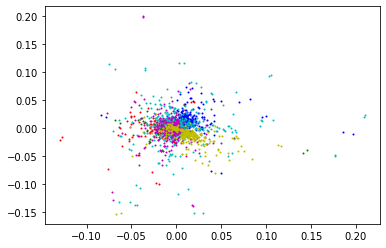

In [200]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
transformer = decomposition.PCA(n_components=70,
        random_state=0)
#feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_sgc))
feature_pca = transformer.fit_transform(feature_smoothed_ssgc/D)
visualize(feature_pca[:,3],feature_pca[:,4],labels)



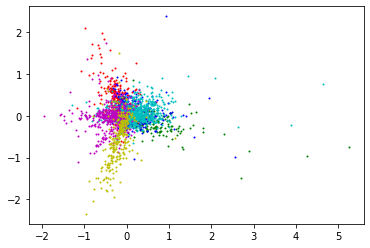

In [219]:
feature_pca = transformer.fit_transform(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)))
#feature_pca = transformer.fit_transform(feature_smoothed_poisson*(torch.sqrt(D)))
visualize(feature_pca[:,2],feature_pca[:,3],labels)


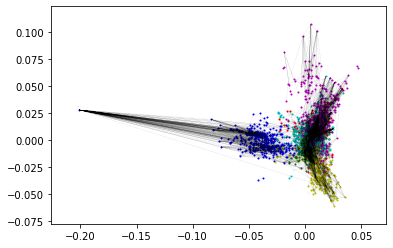

In [84]:
pca = decomposition.FastICA(n_components=512)
feature_ica = pca.fit_transform(feature_smoothed_ssgc)



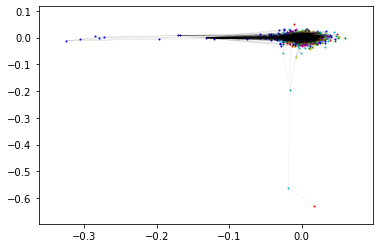

In [66]:
pca = decomposition.PCA(n_components=4)
feature_pca = pca.fit_transform(feature_smoothed_ssgc)
#visualize(feature_pca[:,2],feature_pca[:,3],labels,lap_normalized)


In [215]:
classify(feature_smoothed_poisson*D, args.dataset, per_class='20')
classify(feature_smoothed_poisson*D, args.dataset, per_class='5')
#*torch.sqrt(D)
#*torch.sqrt(D)

80.23887973640856
1.4146951855702474
69.57088703563305
3.8139927357096903


In [221]:
#F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)
classify(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D)), args.dataset, per_class='5')

81.22487644151566
1.3326510483065803
72.48369977255497
2.828739659096614


In [224]:
classify(F.normalize(feature_smoothed_ssgc)*(torch.sqrt(D)), args.dataset, per_class='20')
classify(F.normalize(feature_smoothed_ssgc)*(torch.sqrt(D)), args.dataset, per_class='5')

81.33855024711697
1.3807687499897066
70.80060652009097
3.7979237665655683


In [223]:
classify(feature_smoothed_ssgc, args.dataset, per_class='20')
classify(feature_smoothed_ssgc, args.dataset, per_class='5')

79.1993410214168
1.412774431511243
69.6702047005307
4.50712590901905


In [288]:
nnLinear_input = torch.tensor(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D))).float()

neg_sample = torch.from_numpy(load_adj_neg(args.num_nodes, args.sample)).float().to(device)

model = Net(args).to(device)
#args.num_features = 512
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
model.train()
Lambda = 0.9
for epoch in range(args.epochs):

    optimizer.zero_grad()
    out = model(nnLinear_input)

    loss = (Lambda*torch.trace(torch.mm(torch.mm(torch.transpose(out, 0, 1), neg_sample), out)) - torch.trace(
        torch.mm(torch.mm(torch.transpose(out, 0, 1), lap_normalized), out)))/out.shape[0]

    print(loss)
    loss.backward()
    optimizer.step()

model.eval()
emb_origin = model(nnLinear_input).cpu().detach().numpy()

/tmp/ipykernel_552/267122379.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nnLinear_input = torch.tensor(F.normalize(feature_smoothed_poisson)*(torch.sqrt(D))).float()


tensor(-0.3439, grad_fn=<DivBackward0>)
tensor(-0.4905, grad_fn=<DivBackward0>)
tensor(-0.6811, grad_fn=<DivBackward0>)
tensor(-0.9186, grad_fn=<DivBackward0>)
tensor(-1.2056, grad_fn=<DivBackward0>)
tensor(-1.5448, grad_fn=<DivBackward0>)
tensor(-1.9389, grad_fn=<DivBackward0>)
tensor(-2.3905, grad_fn=<DivBackward0>)
tensor(-2.9026, grad_fn=<DivBackward0>)
tensor(-3.4779, grad_fn=<DivBackward0>)
tensor(-4.1192, grad_fn=<DivBackward0>)
tensor(-4.8294, grad_fn=<DivBackward0>)
tensor(-5.6115, grad_fn=<DivBackward0>)
tensor(-6.4682, grad_fn=<DivBackward0>)
tensor(-7.4026, grad_fn=<DivBackward0>)
tensor(-8.4174, grad_fn=<DivBackward0>)
tensor(-9.5157, grad_fn=<DivBackward0>)
tensor(-10.7002, grad_fn=<DivBackward0>)
tensor(-11.9740, grad_fn=<DivBackward0>)
tensor(-13.3399, grad_fn=<DivBackward0>)
tensor(-14.8008, grad_fn=<DivBackward0>)
tensor(-16.3595, grad_fn=<DivBackward0>)
tensor(-18.0188, grad_fn=<DivBackward0>)
tensor(-19.7816, grad_fn=<DivBackward0>)
tensor(-21.6506, grad_fn=<DivBack

In [289]:
classify(emb_origin, args.dataset, per_class='20')
classify(emb_origin, args.dataset, per_class='5')

82.52883031301482
1.2419932658776671
77.33510235026536
2.542282631790712


In [249]:
classify(F.normalize(torch.tensor(emb_origin))*torch.sqrt(D), args.dataset, per_class='20')
classify(F.normalize(torch.tensor(emb_origin))*torch.sqrt(D), args.dataset, per_class='5')

79.20593080724878
1.239604663645836
72.36467020470053
4.139218359894372


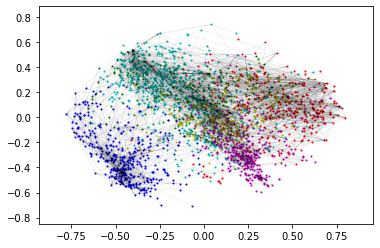

In [271]:
pca = decomposition.PCA(n_components=10)
feature_pca = pca.fit_transform(F.normalize(torch.tensor(emb_origin)*torch.sqrt(D)))
#feature_pca = pca.fit_transform(torch.tensor(emb_origin))
visualize(feature_pca[:,1],feature_pca[:,2],labels,lap_normalized,0.2)

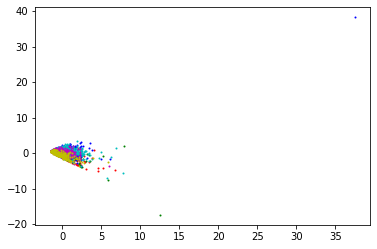

In [286]:
pca = decomposition.PCA(n_components=10)
feature_pca = pca.fit_transform(feature*torch.sqrt(D))
#feature_pca = pca.fit_transform(torch.tensor(emb_origin))
visualize(feature_pca[:,0],feature_pca[:,1],labels)

In [283]:
classify(torch.tensor(feature)*torch.sqrt(D), args.dataset, per_class='20')
classify(torch.tensor(feature)*torch.sqrt(D), args.dataset, per_class='5')

/tmp/ipykernel_552/1422734233.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classify(torch.tensor(feature)*torch.sqrt(D), args.dataset, per_class='20')


57.52388797364085
1.8628795398516167


/tmp/ipykernel_552/1422734233.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  classify(torch.tensor(feature)*torch.sqrt(D), args.dataset, per_class='5')


40.917361637604245
3.9503185961333878


/tmp/ipykernel_552/1515621387.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature_pca = pca.fit_transform(F.normalize(torch.tensor(feature)))


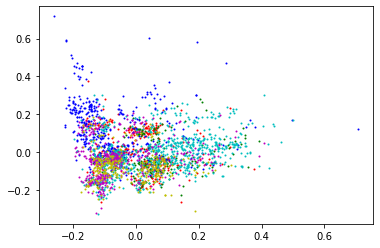

In [277]:
pca = decomposition.PCA(n_components=10)
feature_pca = pca.fit_transform(F.normalize(torch.tensor(feature)))
#feature_pca = pca.fit_transform(torch.tensor(emb_origin))
visualize(feature_pca[:,1],feature_pca[:,2],labels)

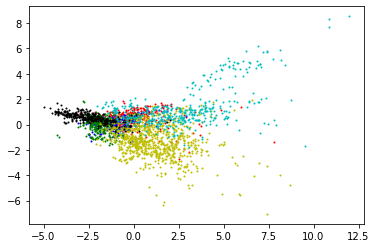

In [6]:

from sklearn import decomposition
from sklearn import datasets
from sklearn.preprocessing import StandardScaler


import numpy as np
pca = decomposition.PCA(n_components=4)
emb_pca = pca.fit_transform(emb_origin)

import matplotlib.pyplot as plt
import matplotlib



emb_pca_x = emb_pca[:,1]
emb_pca_y = emb_pca[:,2]
ss = 1
#plt.scatter(emb_pca_x,emb_pca_y,s=ss,color='r')
plt.scatter(emb_pca_x[np.nonzero(labels == 0)],emb_pca_y[np.nonzero(labels == 0)],s=ss,color='r')
plt.scatter(emb_pca_x[np.nonzero(labels == 1)],emb_pca_y[np.nonzero(labels == 1)],s=ss,color='b')
plt.scatter(emb_pca_x[np.nonzero(labels == 2)],emb_pca_y[np.nonzero(labels == 2)],s=ss,color='g')
plt.scatter(emb_pca_x[np.nonzero(labels == 3)],emb_pca_y[np.nonzero(labels == 3)],s=ss,color='y')
plt.scatter(emb_pca_x[np.nonzero(labels == 4)],emb_pca_y[np.nonzero(labels == 4)],s=ss,color='c')
plt.scatter(emb_pca_x[np.nonzero(labels == 5)],emb_pca_y[np.nonzero(labels == 5)],s=ss,color='k')

In [7]:
neg_sample = torch.from_numpy(load_adj_neg(args.num_nodes, args.sample)).float().to(device)

model_orth = Net(args,bias=False).to(device)
optimizer = torch.optim.Adam(model_orth.parameters(), lr=args.lr, weight_decay=args.weight_decay)


In [8]:
model_orth.train()
Lambda = 0.9
for epoch in range(args.epochs):

    optimizer.zero_grad()
    out = model_orth(feature_smoothed_ssgc)

    loss = (Lambda*torch.trace(torch.mm(torch.mm(torch.transpose(out, 0, 1), neg_sample), out)) - torch.trace(
        torch.mm(torch.mm(torch.transpose(out, 0, 1), lap_normalized), out)))/out.shape[0] + torch.norm(
        torch.mm(model_orth.conv1.weight,torch.transpose( model_orth.conv1.weight,0,1)) - torch.eye(args.output) )

    print(loss)
    loss.backward()
    optimizer.step()

model_orth.eval()
emb_orth = model_orth(feature_smoothed_ssgc).cpu().detach().numpy()

tensor(15.3917, grad_fn=<AddBackward0>)
tensor(14.6188, grad_fn=<AddBackward0>)
tensor(13.8078, grad_fn=<AddBackward0>)
tensor(12.9652, grad_fn=<AddBackward0>)
tensor(12.0986, grad_fn=<AddBackward0>)
tensor(11.2158, grad_fn=<AddBackward0>)
tensor(10.3244, grad_fn=<AddBackward0>)
tensor(9.4307, grad_fn=<AddBackward0>)
tensor(8.5399, grad_fn=<AddBackward0>)
tensor(7.6556, grad_fn=<AddBackward0>)
tensor(6.7805, grad_fn=<AddBackward0>)
tensor(5.9171, grad_fn=<AddBackward0>)
tensor(5.0686, grad_fn=<AddBackward0>)
tensor(4.2398, grad_fn=<AddBackward0>)
tensor(3.4378, grad_fn=<AddBackward0>)
tensor(2.6745, grad_fn=<AddBackward0>)
tensor(1.9689, grad_fn=<AddBackward0>)
tensor(1.3514, grad_fn=<AddBackward0>)
tensor(0.8661, grad_fn=<AddBackward0>)
tensor(0.5620, grad_fn=<AddBackward0>)
tensor(0.4584, grad_fn=<AddBackward0>)
tensor(0.5045, grad_fn=<AddBackward0>)
tensor(0.5975, grad_fn=<AddBackward0>)
tensor(0.6438, grad_fn=<AddBackward0>)
tensor(0.5923, grad_fn=<AddBackward0>)
tensor(0.4319, gra

In [9]:
classify(emb_orth, args.dataset, per_class='20')
classify(emb_orth, args.dataset, per_class='5')

81.28747940691926
1.2648540416415366
72.6125852918878
4.0209714759837905


In [10]:
torch.norm(
        torch.mm(model.conv1.weight,torch.transpose( model.conv1.weight,0,1)) - torch.eye(args.output) )

tensor(797.7436, grad_fn=<CopyBackwards>)

In [11]:
torch.mm(model.conv1.weight,torch.transpose( model.conv1.weight,0,1))

tensor([[ 2.9761, -1.2811, -1.5181,  ..., -1.0226,  0.3866, -0.0861],
        [-1.2811,  2.7082,  1.3592,  ...,  0.9601,  0.0678, -0.2221],
        [-1.5181,  1.3592,  3.0880,  ...,  1.6565,  0.6717, -0.9721],
        ...,
        [-1.0226,  0.9601,  1.6565,  ...,  2.8898,  1.2071, -0.7645],
        [ 0.3866,  0.0678,  0.6717,  ...,  1.2071,  2.9864, -1.2309],
        [-0.0861, -0.2221, -0.9721,  ..., -0.7645, -1.2309,  2.9186]],
       grad_fn=<MmBackward0>)

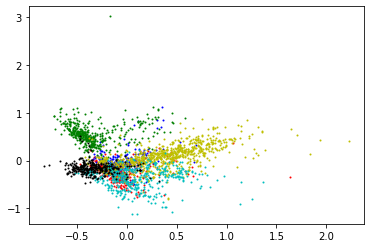

In [12]:
import numpy as np
pca = decomposition.PCA(n_components=4)
emb_pca = pca.fit_transform(emb_orth)

import matplotlib.pyplot as plt
import matplotlib



emb_pca_x = emb_pca[:,1]
emb_pca_y = emb_pca[:,2]
ss = 1
#plt.scatter(emb_pca_x,emb_pca_y,s=ss,color='r')
plt.scatter(emb_pca_x[np.nonzero(labels == 0)],emb_pca_y[np.nonzero(labels == 0)],s=ss,color='r')
plt.scatter(emb_pca_x[np.nonzero(labels == 1)],emb_pca_y[np.nonzero(labels == 1)],s=ss,color='b')
plt.scatter(emb_pca_x[np.nonzero(labels == 2)],emb_pca_y[np.nonzero(labels == 2)],s=ss,color='g')
plt.scatter(emb_pca_x[np.nonzero(labels == 3)],emb_pca_y[np.nonzero(labels == 3)],s=ss,color='y')
plt.scatter(emb_pca_x[np.nonzero(labels == 4)],emb_pca_y[np.nonzero(labels == 4)],s=ss,color='c')
plt.scatter(emb_pca_x[np.nonzero(labels == 5)],emb_pca_y[np.nonzero(labels == 5)],s=ss,color='k')

In [13]:
cora without orth
82.26276771004942
1.254241627563159
77.16148597422288
2.6389531638400907
with orth
81.75947281713344
1.246101318967512
72.3131159969674
4.046646313156723
with raw feature_smoothed_ssgc
81.59390444810545
1.2038835463852553
71.03032600454888
4.572080755555725

citeseer without orth
70.42112082928408
1.1220317077364168
66.50749923477197
2.431697731089557
with orth
70.94978943958535
1.0752492722237095
66.09978573614937
2.540035128432411
with raw feature_smoothed_ssgc
69.89050858438614
1.2455656779678324
60.153657790021434
4.213946942708061


pubmed without orth
40 epoch
74.67142930040312   claimed 77.4±1.9 
2.381893996454681
64.65291816935033   claimed 66.0±5.2b
5.362018399570344

with ort
40 epoch
74.04715007399092
2.5807319620069507
66.49210138670189
4.908270660412052

raw feature feature_smoothed_ssgc
74.04715007399092
2.5807319620069507
66.49210138670189
4.908270660412052

pubmed 80 epoch wihtout orth
73.68137980303108    
2.4570598828041033
63.52598161223142    
5.489841045145188

pubmed 80 epoch with orth
72.51885492677451
2.5179344333050375
66.14364809264997
4.886909664894386

SyntaxError: invalid syntax (3253365344.py, line 1)